### ***Cultural Health Moments:*** 
A Search Analysis During Times of Heightened Awareness To Identify Potential Interception Points With Digital Health Consumers.

### ***Project Contributors:***
> Sirui Yang

> Kuzi Rusere

> Ye An

> Umair Shaikh

* ***Vision:*** Understanding how cultural health moments impact health consumers’ digital search behavior may provide insight into potential interception points relating to disease-state awareness, education, symptoms, diagnosis, and/or treatment.
<br>
<br>
* ***Issue:*** During high-profile health moments (ex. – the cancer-related deaths of Chadwick Boseman and Eddie Van Halen, or the cancer diagnosis of Jimmy Carter or Rush Limbaugh) digital health consumers’ initial search queries are typically surface-level search (ex. – scandal, wealth, career highlights, spouse, etc.), but that search behavior shifts to awareness, signs, symptoms, and introspection over time. Understanding that time horizon – when the shift occurs and what common topical trends exist – may provide opportunities to engage by leveraging naturally occurring awareness and search.
<br>
<br>
* ***Method:*** Examination of publicly available search data as related to high-profile disease state diagnosis and/or deaths. <br>
<br>
For the data collection in this project we are going to use Google Trend specifically PyTrends. Google Trends => is a website by Google that analyzes the popularity of top search queries in Google Search across various regions and languages. The website uses graphs to compare the search volume of different queries over time. PyTrends inturn is a Python library/module/API that Allows simple interface for automating downloading of reports from Google Trends <br>
<br>
The data/reports from Google Trends are given as relative popularity and not the actual search volume. <br> <br>
From [Google Trends]("https://support.google.com/trends/answer/4365533?hl=en") =>
"*Google Trends normalizes search data to make comparisons between terms easier. Search results are normalized to the time and location of a query by the following process:*"

> 1. Each data point is divided by the total searches of the geography and time range it represents to compare relative popularity. Otherwise, places with the most search volume would always be ranked highest.

> 2. The resulting numbers are then scaled on a range of 0 to 100 based on a topic’s proportion to all searches on all topics.

> 3. Different regions that show the same search interest for a term don't always have the same total search volumes.

* ***Potential Output:*** Present a use case identifying the window of heightened awareness and interest among health consumers caused by cultural health moments for use within strategic campaign development for advocacy groups (ex. – Komen, American Cancer Society), payers (Aetna, Blue Cross), and/or healthcare companies.

In [1]:
#importing the needed libraries, we will use the pandas dataframe to store the data from Google Trends 
import pytrends
import time
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets, Layout
import plotly.express as px
from IPython import display
from IPython.core.display import display, HTML
from wordcloud import WordCloud
#we will have to import TrendReq from PyTrends to request data from Google Trends 
from pytrends.request import TrendReq

We have gathered a list of high-profile people that have been diagnosed with chronic diseases or have died from chronic diseases. The list has the name of the high-profile person and at least one important date. The important date is going to be either the date that they got diagnosed, the date that they announced that they had the chronic disease, or the date that they passed away from the chronic disease. The names and chronic disease are going to be used as keywords in Google Trends and the important dates will be used as the time interval.
<br>
<br>
The list was saved into a CSV file called Cultural_Health_Moments.csv  and we will load that into a pandas dataframe.

In [2]:
#loading the list into a pandas dataframe
data = pd.read_csv('Cultural_Health Moments_Data.csv')

We're going to convert the important dates columns into pandas datetime

In [3]:
data['Important_Date_1'] =  pd.to_datetime(data['Important_Date_1'])
data['Important_Date_2'] =  pd.to_datetime(data['Important_Date_2'])

In [4]:
data

,Name_of_HPP,Chronic_Condition,Important_Date_1,Important_Date_2
0,Selena Gomez,Lupus,2017-09-14,NaT
1,Lena Dunham,Endometriosis,2018-02-14,NaT
2,Nick Cannon,Lupus,2012-01-04,2016-04-14
3,Charlie Sheen,HIV,2015-11-17,NaT
4,Tom Hanks,Diabetes,2013-10-07,NaT
5,Jack Osbourne,Multiple Sclerosis,2012-06-18,NaT
6,Nick Jonas,Diabetes,2007-03-15,2019-11-01
7,Ben Stiller,Prostate Cancer,2014-06-13,2016-10-04
8,Lady Gaga,Fibromyalgia,2017-09-12,NaT
9,Alex Trebek,Pancreatic Cancer,2019-03-01,2020-11-08


In [5]:
#hl is the host language, 
#tz is the time zone and 
# retries is the number of retries total/connections/read all represented by one scalar
pytrend = TrendReq(hl = 'en-US', tz = 0, retries=10)

We are going to first use the 'pytrends.suggestion' function which returns a list of additional suggested keywords that can be used to refine a trend search. The “mid” column in the resulting dataframe contains those exact keywords we’d like to search. <br>

We will first do for the Name of High Profile Person column and the Chronic_Condition column saving these in seperate dataframes.

In [6]:
KEYWORDS= list(data.Name_of_HPP)
KEYWORDS_CODES=[pytrend.suggestions(keyword=i)[0] for i in KEYWORDS] 
df_HPP= pd.DataFrame(KEYWORDS_CODES)
df_HPP

,mid,title,type
0,/m/0gs6vr,Selena Gomez,American singer
1,/m/0b3w054,Lena Dunham,American actress
2,/m/01d1st,Nick Cannon,American comedian
3,/m/01pllx,Charlie Sheen,American actor
4,/m/0bxtg,Tom Hanks,American actor
5,/m/02348n,Jack Osbourne,Media personality
6,/m/04f7c55,Nick Jonas,American singer-songwriter
7,/m/0mdqp,Ben Stiller,American actor
8,/m/0478__m,Lady Gaga,American singer-songwriter
9,/m/01tbdb,Alex Trebek,Canadian-American game show host


In [7]:
KEYWORDS= list(data.Chronic_Condition)
KEYWORDS_CODES=[pytrend.suggestions(keyword=i)[0] for i in KEYWORDS] 
df_CC= pd.DataFrame(KEYWORDS_CODES)
df_CC

,mid,title,type
0,/m/04nz3,Systemic lupus erythematosus,Disease
1,/m/0d_9n,Endometriosis,Disease
2,/m/04nz3,Systemic lupus erythematosus,Disease
3,/m/03nky3,Hives,Medical condition
4,/m/0c58k,Diabetes,Disorder
5,/m/0dcqh,Multiple sclerosis,Disease
6,/m/0c58k,Diabetes,Disorder
7,/m/0m32h,Prostate cancer,Disease
8,/m/01v3ks,Fibromyalgia,Medical condition
9,/m/01_qc_,Pancreatic cancer,Topic


We are going to create a supporting fuction to create the date interval

In [8]:
def create_date_interval(date):
    """
    This fuction creates the date interval needed for as one of the parameters for the pytrend.build_payload fuction
    The function takes in the important date and returns a string of the date interval +/- 30 days
    """
    start_date = date - datetime.timedelta(days= 30)
    end_date = date + datetime.timedelta(days=30)

    x = (str(start_date)).split()[0]
    y = (str(end_date)).split()[0]
    
    date_interval = f"{x} {y}"

    return date_interval

We will create a function that will output a dataframe of the Google Trends search data results

In [52]:
def dataframe_of_trends(num):
    """
    This fuction outputs a dataframe of the trends data/results from google trends
    It inputs the index from the 'data' dataframe which is housing the Cultural health moments High Profile people and chronic condition data 
    it will also output dictionary of the 'related, top and rising queries' which we will need for later.  
    """
    #setting up the parameters for the payload
    KEYWORDS=[df_HPP.mid[num], df_CC.mid[num]]
    DATE_INTERVAL= create_date_interval(data.Important_Date_1[num])
    COUNTRY="US" 
    CATEGORY = 0 
    SEARCH_TYPE=''
    #######################
    #the below is building the payload using the above parameters
    pytrend.build_payload( kw_list= KEYWORDS, timeframe = DATE_INTERVAL, geo = COUNTRY, cat=CATEGORY,gprop=SEARCH_TYPE) 
    df = pytrend.interest_over_time() #we will  assign the interest_overtime/trends dataframe to df
    #now we will rename the column name from the pytrends suggested mid value to the actual name of the high profile person and chronic condition 
    df = df.rename(columns={KEYWORDS[0]: data.Name_of_HPP[num], KEYWORDS[1]: data.Chronic_Condition[num]})
    df.drop('isPartial', axis=1, inplace=True)

    #now we will grab the dictionary of the related, top and rising queries and rename the keys
    related_queries = pytrend.related_queries()
    related_queries[data.Name_of_HPP[num]] = related_queries.pop(KEYWORDS[0])
    related_queries[data.Chronic_Condition[num]] = related_queries.pop(KEYWORDS[1])
    #now we will seperate the dictionary into HPP_related_queries and the CC_related_queries 
    HPP_related_queries = related_queries[data.Name_of_HPP[num]]
    CC_related_queries = related_queries[data.Chronic_Condition[num]]

    df_region = pytrend.interest_by_region()
    #now we will rename the column name from the pytrends suggested mid value to the actual name of the high profile person and chronic condition 
    df_region.reset_index(inplace=True)
    df_region = df_region.rename(columns={'geoName':'State',KEYWORDS[0]: data.Name_of_HPP[num], KEYWORDS[1]: data.Chronic_Condition[num]})
    

    return df, HPP_related_queries, CC_related_queries, DATE_INTERVAL, df_region

In [53]:
df, HPP_related_queries, CC_related_queries, date_interval, df_region = dataframe_of_trends(10)

In [32]:
df

,Chadwick Boseman,Colon Cancer
date,,
2020-07-29,0,0
2020-07-30,0,0
2020-07-31,0,0
2020-08-01,0,0
2020-08-02,0,0
...,...,...
2020-09-23,0,0
2020-09-24,0,0
2020-09-25,0,0


We will create a function that plots out the trends between the high profile person and the chronic condition within the date interval

In [33]:
def show_the_trend(df,date_interval):
    """   
    This fuction plotout the trend of the High Profile Person and the Chronic Condition within the date interval
    """
    sns.set(rc={'figure.figsize':(15,10)})
    sns.lineplot(data=df).set_title(f"Search Plot of {df.columns[0]} and {df.columns[1]} in the date interval {date_interval}")


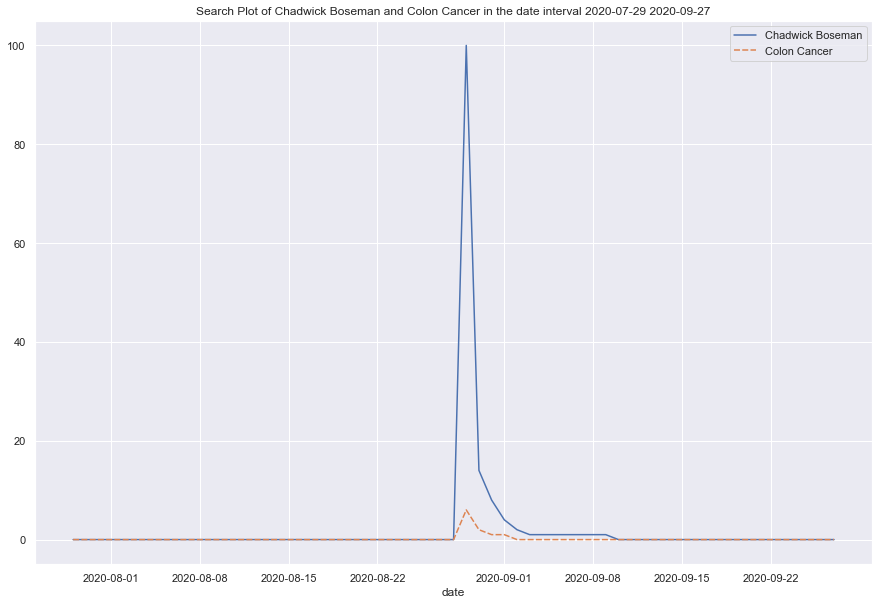

In [34]:
show_the_trend(df,date_interval)

We created a function that will separate the top related queries and the rising related queries

In [35]:
def get_top_and_rising(related_queries_dict):
    """  
    This fuction returns the top and rising related queries 
    """
    # for rising related queries
    related_queries_rising = related_queries_dict.get('rising')
    # for top related queries
    related_queries_top = related_queries_dict.get('top')

    return related_queries_rising, related_queries_top

We found a function on [StackOverflow](https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side) that allows us to display data frames of the top related queries and rising related queries side by side, so we're going to be utilizing that to show these trends side by side fist for the High Profile Person and then the Chronic condition.

In [36]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [37]:
related_queries_rising, related_queries_top = get_top_and_rising(HPP_related_queries)
df1 = related_queries_top
df2 = related_queries_rising
display_side_by_side([df1, df2], [f'Top Related Quires for {df.columns[0]}', f'Rising Related Quiries for {df.columns[0]}'])

,query,value
0,chadwick,100
1,boseman,100
2,chadwick boseman,96
3,chadwick wife,9
4,boseman wife,8
5,chadwick boseman wife,8
6,black panther,7
7,chadwick boseman dead,7
8,black panther chadwick boseman,7
9,chadwick black panther,7


In [38]:
def bar_chart(df):
    fig = px.bar(df, x=f'{df.columns[1]}', y=f'{df.columns[0]}')
    fig.show()

In [39]:
def wordcloud_of_related_queries(df, title):
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [40]:
bar_chart(df1)

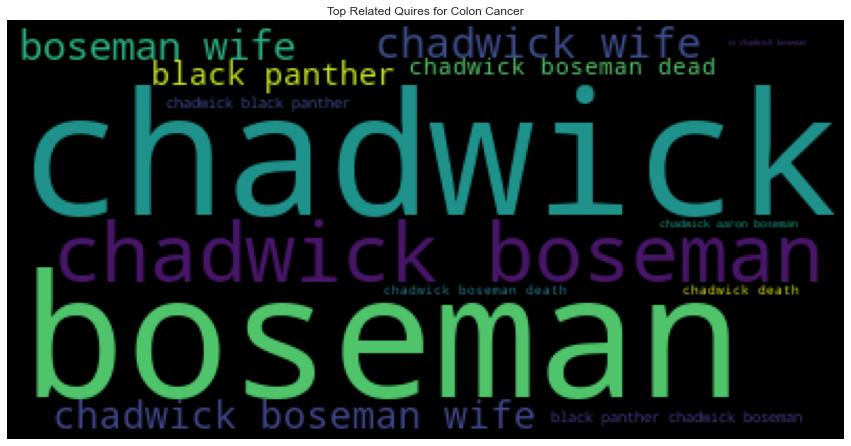

In [41]:
wordcloud_of_related_queries(df1, f'Top Related Quires for {df.columns[1]}')

In [42]:
bar_chart(df2)

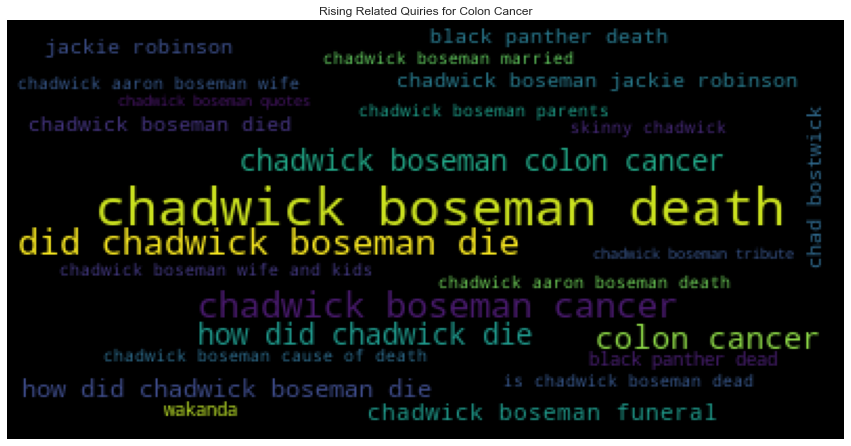

In [43]:
wordcloud_of_related_queries(df2, f'Rising Related Quiries for {df.columns[1]}')

In [44]:
related_queries_rising, related_queries_top = get_top_and_rising(CC_related_queries)
df1 = related_queries_top
df2 = related_queries_rising
display_side_by_side([df1, df2], [f'Top Related Quires for {df.columns[1]}', f'Rising Related Quiries for {df.columns[1]}'])

,query,value
0,colon cancer,100
1,colon,97
2,colon cancer symptoms,25
3,colon cancer signs,14
4,chadwick,13
5,chadwick boseman,12
6,colorectal,12
7,chadwick boseman colon cancer,12
8,signs of colon cancer,9
9,symptoms of colon cancer,9


In [45]:
bar_chart(df1)

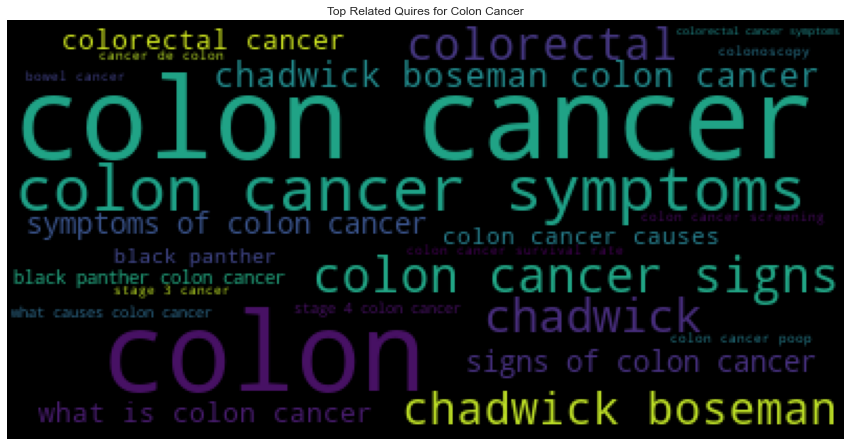

In [46]:
wordcloud_of_related_queries(df1, f'Top Related Quires for {df.columns[1]}')

In [47]:
bar_chart(df2)

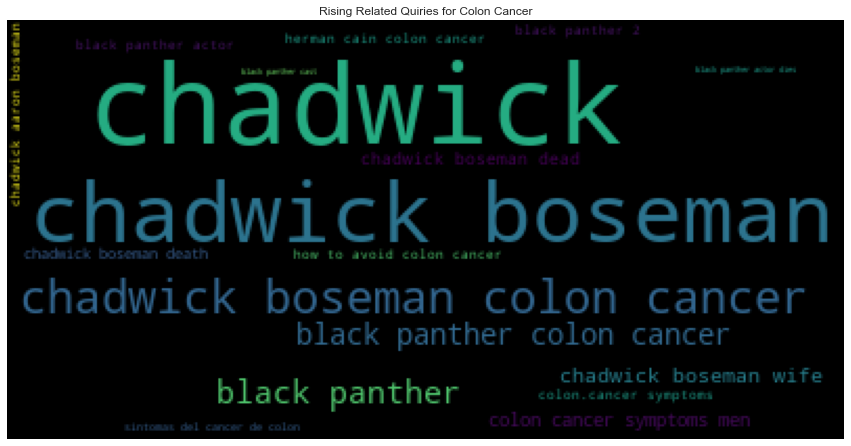

In [48]:
wordcloud_of_related_queries(df2, f'Rising Related Quiries for {df.columns[1]}')

In [54]:
df_region

,State,Chadwick Boseman,Colon Cancer
0,Alabama,88,12
1,Alaska,91,9
2,Arizona,89,11
3,Arkansas,91,9
4,California,87,13
5,Colorado,88,12
6,Connecticut,89,11
7,Delaware,87,13
8,District of Columbia,90,10
9,Florida,88,12


In [51]:
code = {'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'}

In [56]:
df_region['Code'] = df_region['State'].map(code)


In [71]:
fig = px.choropleth(df_region,
                    locations='Code',
                    color=f'{df_region.columns[1]}',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')

fig.show()


In [72]:
fig = px.choropleth(df_region,
                    locations='Code',
                    color=f'{df_region.columns[2]}',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')

fig.show()